In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OSÏóê Îî∞Îùº Í∏∞Î≥∏ Ìè∞Ìä∏ ÏÑ§Ï†ï
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows Í∏∞Î≥∏ ÌïúÍ∏Ä Ìè∞Ìä∏
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    # Mac Í∏∞Î≥∏ ÌïúÍ∏Ä Ìè∞Ìä∏
else:
    # Î¶¨ÎàÖÏä§: ÎÇòÎàîÍ≥†Îîï ÎòêÎäî ÏÑ§ÏπòÎêú ÌïúÍ∏Ä Ìè∞Ìä∏ ÌôïÏù∏ ÌïÑÏöî
    plt.rcParams['font.family'] = 'NanumGothic'     # ÎòêÎäî 'DejaVu Sans' Îì±

# ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.contingency_tables import cochrans_q

from scipy.stats import ttest_ind , chi2_contingency

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv",index_col=0)
df = df.drop(columns = 'id', axis = 1)
df.head(3)

Gender  Age  Height  Weight family_history_with_overweight FAVC       FCVC  \
0   male   27    1.80      87                             no   no     always   
1   male   26    1.85     105                            yes  yes     always   
2   male   41    1.80      99                             no  yes  sometimes   

   NCP        CAEC SMOKE               CH2O SCC     FAF     TUE        CALC  \
0    3   sometimes    no  between 1 and 2 l  no  2 to 4  0 to 2  frequently   
1    3  frequently    no      more than 2 l  no  2 to 4      >5   sometimes   
2    3   sometimes    no  between 1 and 2 l  no  2 to 4  3 to 5  frequently   

                  MTRANS          NObeyesdad        BMI  
0                walking  overweight_level_i  26.851852  
1  public_transportation      obesity_type_i  30.679328  
2             automobile      obesity_type_i  30.555556

In [3]:
## 1) EDA, Í≤∞Ï∏°, Ïù¥ÏÉÅÏπò 

In [4]:
# 1) Í≤∞Ï∏°
display(df.isna().sum().to_frame().T)

Gender  Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       0    0       0       0                               0     0     0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  BMI  
0    0     0      0     0    3    0    0     0       0           0    0

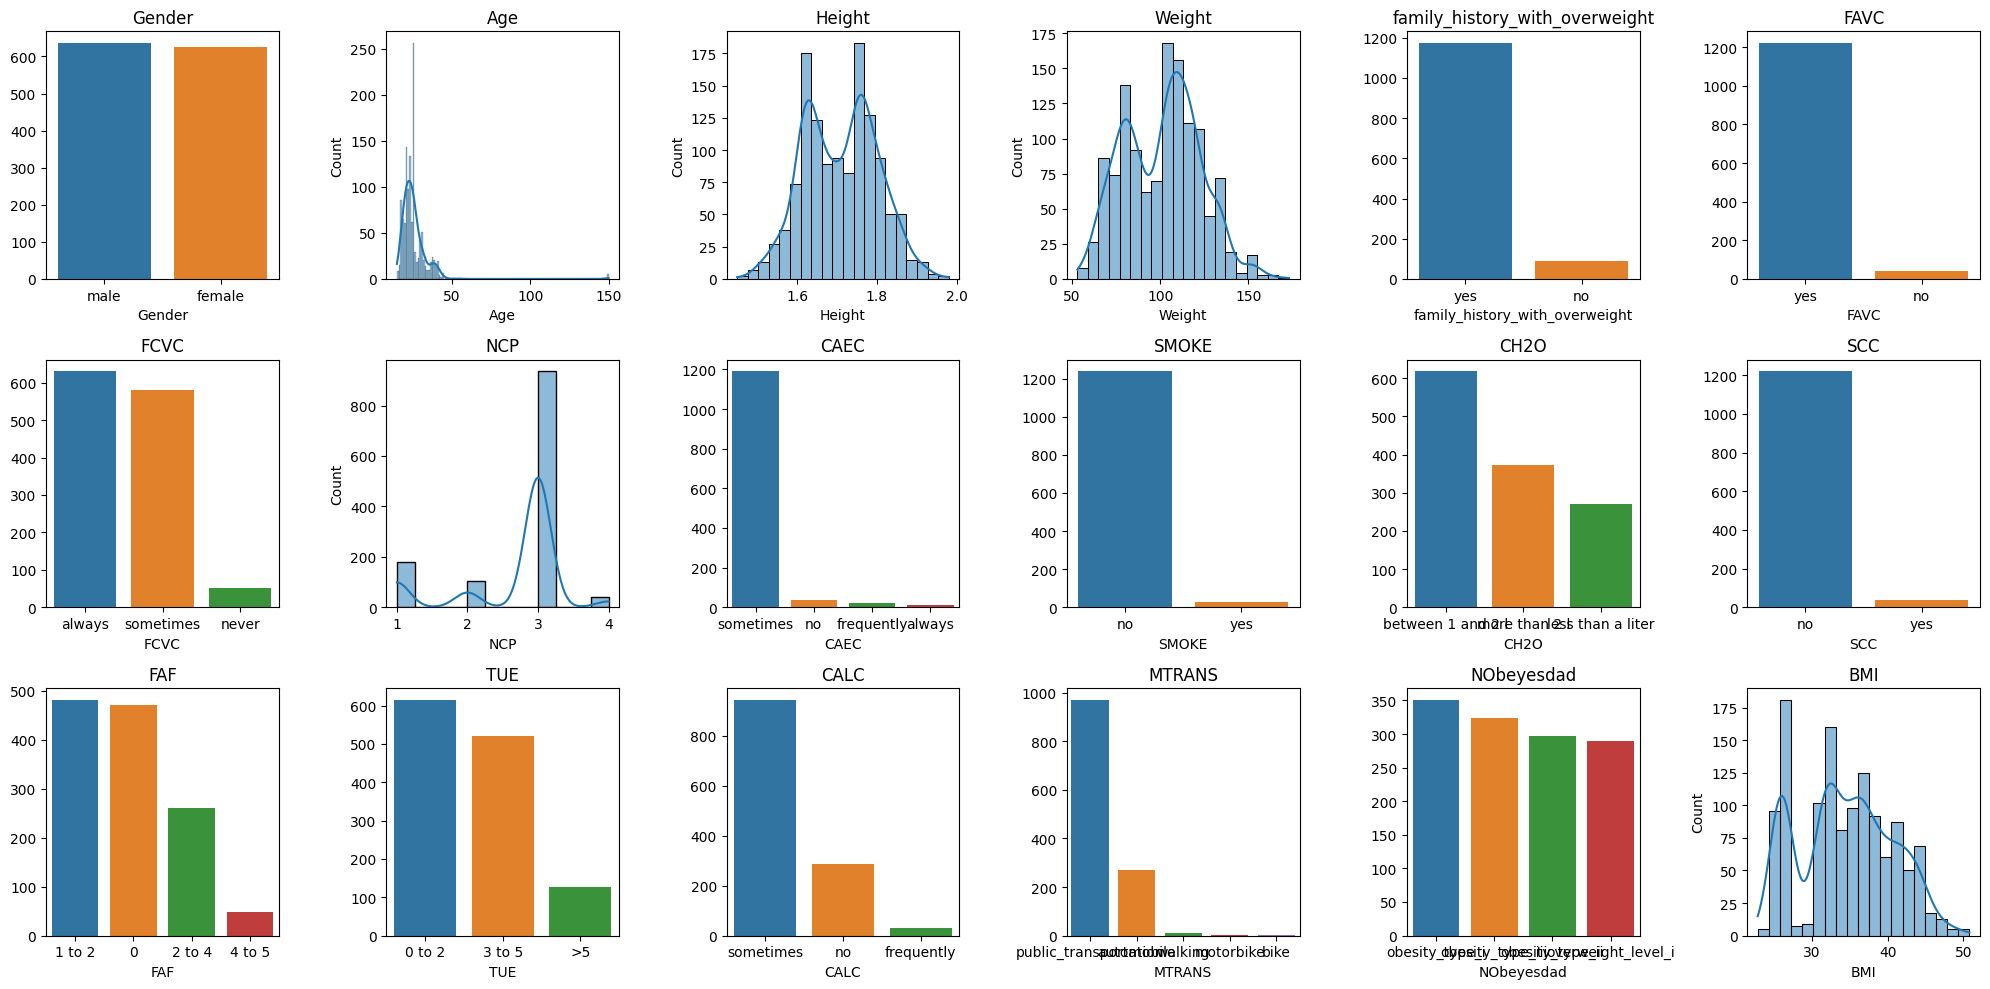

In [5]:
# 2) EDA 
fig, axes = plt.subplots(3,6, figsize= (20, 10) )
for axes, col in zip(axes.flatten() , df.columns)  : 
    if df[col].dtypes == 'object' and df[col].nunique() == 2 : 
        target = df[col].value_counts() 
        sns.barplot(x = target.index, y = target.values, hue = target.index, ax = axes)
        axes.set_title(f'{col}') 

    elif df[col].dtypes == 'object' and 3 <= df[col].nunique() < 6 : 
        target = df[col].value_counts()
        sns.barplot(x = target.index, y = target.values, hue = target.index, ax = axes)
        axes.set_title(f'{col}')  

    else : 
        sns.histplot(df[col], kde = True, ax = axes)
        axes.set_title(f'{col}')

plt.tight_layout()
plt.show()

<Axes: >

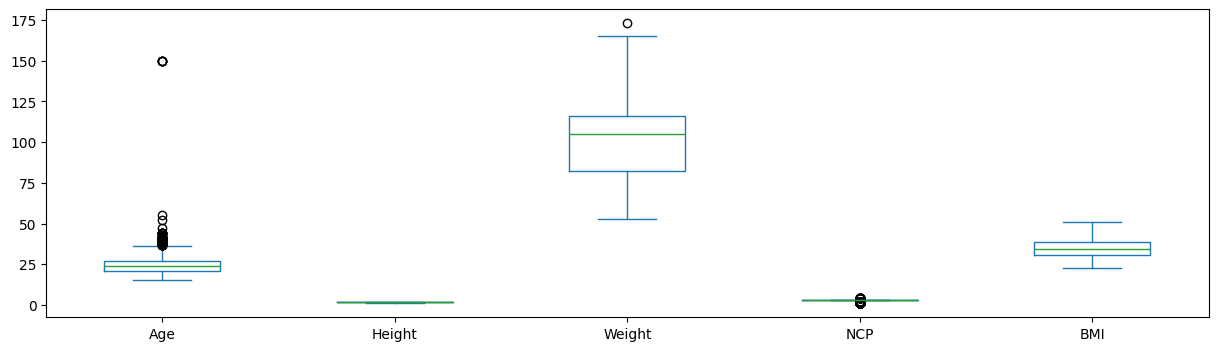

In [6]:
## Ïù¥ÏÉÅÏπò - Ïà´ÏûêÌòï Î≥ÄÏàòÎßå 
num_cols = df.select_dtypes(exclude = 'object').columns

fig, axes = plt.subplots(1,1, figsize = (15,4))
df[num_cols].plot(kind = 'box', ax = axes)

In [7]:
## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Í∏∞Î≤ï 

# 1) Í≤∞Ï∏° Ï≤òÎ¶¨ 
df1 = df.dropna().reset_index(drop = True)

# 2) Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨ ÎÇòÏù¥ 100 Ïù¥Ìïò 
df2 = df1[df1['Age'] <= 100].reset_index(drop = True)

# 3) Ï†ÑÏ≤òÎ¶¨ 
clean_df = pd.DataFrame()
for col in df2.columns : 
    if df2[col].nunique() == 2 : 
        dummies = pd.get_dummies(df2[col] , prefix = col, dtype = int) 
        for d_col in dummies.columns : 
            clean_df[d_col] = dummies[d_col] 

    elif 3 <= df2[col].nunique() < 6 :
        la = LabelEncoder()
        clean_df[col] = la.fit_transform(df2[col]) 

    else : 
        clean_df[col] = StandardScaler().fit_transform(df2[[col]]).flatten() 

clean_df.head()
        

Gender_female  Gender_male       Age    Height    Weight  \
0              0            1  0.287374  1.000803 -0.653360   
1              0            1  0.122295  1.549549  0.184051   
2              0            1  2.598474  1.000803 -0.095086   
3              1            0  0.617531 -1.962423 -1.072065   
4              1            0 -0.372941 -0.645433 -1.444248   

   family_history_with_overweight_no  family_history_with_overweight_yes  \
0                                  1                                   0   
1                                  0                                   1   
2                                  1                                   0   
3                                  1                                   0   
4                                  0                                   1   

   FAVC_no  FAVC_yes  FCVC  ...  SMOKE_yes  CH2O  SCC_no  SCC_yes  FAF  TUE  \
0        1         0     0  ...          0     0       1        0    2    0   
1        0         1     0  ...          0     2       1        0    2    2   
2        0         1     2  ...          0     0       1        0    2    1   
3        0         1     2  ...          0     0       1        0    0    0   
4        1         0     2  ...          0     0       1        0    0    0   

   CALC  MTRANS  NObeyesdad       BMI  
0     0       4           3 -1.243055  
1     2       3           0 -0.616213  
2     0       0           0 -0.636484  
3     1       0           0 -0.183655  
4     2       3           3 -1.429789  

[5 rows x 23 columns]

In [8]:
# ÌååÏÉùÎ≥ÄÏàò 
clean_df['Activity'] = clean_df['FAF'] + clean_df['TUE'] 

In [9]:
# 2-1 ÏïôÏÉÅÎ∏îÏùÑ Ï†úÏô∏Ìïú Î∂ÑÎ•ò Î™®Îç∏ 3Í∞ÄÏßÄ Íµ¨Ï∂ï Î∞è Í≤∞Í≥º ÎπÑÍµê Î∞è ÏÑ§Î™Ö
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score, recall_score 

In [10]:
X = clean_df.drop(columns = 'NObeyesdad' , axis = 1)
y = clean_df['NObeyesdad']

def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    return name, acc, f1 

res = []
for name, model in [['SVC',SVC()] , ['KNN', KNeighborsClassifier()] , ['LG', LogisticRegression(max_iter=1000)]] : 
    name, acc, f1 = classifying_model(name, model)
    res.append({
        'Model' : name, 
        'Accuracy_Score' : acc, 
        'F1_Score' : f1
    })

pd.DataFrame(res)

Model  Accuracy_Score  F1_Score
0   SVC        0.986737  0.986747
1   KNN        0.944297  0.944161
2    LG        0.992042  0.992048

{'Model': 'LogisticRegression',
 'Accuracy_Score': 0.9920424403183024,
 'F1_score': 0.9920475377672314,
 'Precision': 0.9921288406371708,
 'Recall': 0.9920424403183024}

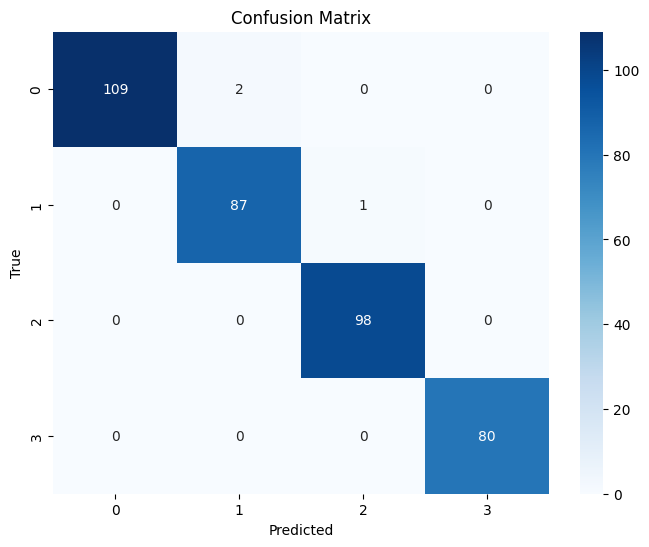

In [11]:
#  2-2 ÏÇ¨Ïö©Ìïú Î™®Îç∏ Ï§ë ÌïòÎÇòÎ•º Í≥®Îùº Í∑∏Î¶¨Îìú ÏÑúÏπòÎ•º ÌÜµÌï¥ÏÑú ÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Î∞è Î∂ÑÎ•ò Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (precision ,recall)
def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)

    params = {
        'C': [0.01, 0.1, 1, 10],        # Í∑úÏ†úÍ∞ïÎèÑ
        'solver': ['liblinear', 'lbfgs'] # ÏµúÏ†ÅÌôî ÏïåÍ≥†Î¶¨Ï¶ò
    }

    grid = GridSearchCV(model, params, cv = 3, scoring = 'accuracy')
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    pred = best_model.predict(x_test) 
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    pre = precision_score(y_test, pred , average = 'weighted')
    recall = recall_score(y_test, pred, average = 'weighted')
    return {
        'Model': name, 
        'Accuracy_Score' : acc, 
        'F1_score' : f1, 
        'Precision' : pre, 
        'Recall' : recall  } , best_model, x_test, y_test

res , best_model, x_test, y_test = classifying_model('LogisticRegression', LogisticRegression(max_iter=1000)) 
display(res) 


# Confusion Maatrix 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
labels = best_model.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
print('''
F1_score : Ï†ïÎ∞ÄÎèÑÏôÄ Ïû¨ÌòÑÏú®Ïùò Ï°∞Ìôî ÌèâÍ∑† 
Ï†ïÎ∞ÄÎèÑ (Precision) : ÏñëÏÑ±ÏúºÎ°ú ÏòàÏ∏°Ìïú Í≤ÉÎì§ Ï§ë 99.2%Í∞Ä Ïã§Ï†ú ÏñëÏÑ± 
Ïû¨ÌòÑÏú® (Recall) : Ïã§Ï†ú ÏñëÏÑ±Ïù∏Í≤ÉÏùÑ 99.2% ÏñëÏÑ±ÏúºÎ°ú ÏòàÏ∏° 
''')


F1_score : Ï†ïÎ∞ÄÎèÑÏôÄ Ïû¨ÌòÑÏú®Ïùò Ï°∞Ìôî ÌèâÍ∑† 
Ï†ïÎ∞ÄÎèÑ (Precision) : ÏñëÏÑ±ÏúºÎ°ú ÏòàÏ∏°Ìïú Í≤ÉÎì§ Ï§ë 99.2%Í∞Ä Ïã§Ï†ú ÏñëÏÑ± 
Ïû¨ÌòÑÏú® (Recall) : Ïã§Ï†ú ÏñëÏÑ±Ïù∏Í≤ÉÏùÑ 99.2% ÏñëÏÑ±ÏúºÎ°ú ÏòàÏ∏° 



In [13]:
# 3Í∞ÄÏßÄ Î™®Îç∏ÏùÑ soft votingÏùÑ Ïù¥Ïö©ÌïòÏó¨ Î™®Îç∏ÎßÅ Ìïú Í≤∞Í≥ºÏôÄ 2-2Ïùò Í≤∞Í≥ºÏôÄ ÎπÑÍµê
print('''
1. Hard Voting : Í∞Å Î™®Îç∏Ïùò ÏµúÏ¢Ö ÏòàÏ∏°ÏùÑ Î™®ÏïÑÏÑú, Í∞ÄÏû• ÎßéÏù¥ ÏÑ†ÌÉùÎêú ÌÅ¥ÎûòÏä§ ÏµúÏ¢Ö ÏòàÏ∏°
                 [A,B,B] = B(2Ìëú) 
                 ÌôïÎ•†Í∞íÏùÑ Î¨¥Ïãú, Ï†ïÎ≥¥ ÏÜêÏã§ 
2. Soft Voting : Í∞Å Î™®Îç∏Ïùò ÏòàÏ∏° ÌôïÎ•†Ïùò ÌèâÍ∑†ÏùÑ ÌÜµÌï¥ÏÑú, ÌôïÎ•†Ïù¥ ÎÜíÏùÄ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° 
                 [A:0.3, B:0.6], [A:0.2, B:0.8], [A:0.4, B:0.6] ‚Üí B ÌèâÍ∑†: 0.67, A ÌèâÍ∑†: 0.3 ‚Üí B                    
                 ÌôïÎ•† ÏòàÏ∏°Ïù¥ ÏßÄÏõêÎêòÎäî Î™®Îç∏ÏùÑ ÏÇ¨Ïö©
''')


1. Hard Voting : Í∞Å Î™®Îç∏Ïùò ÏµúÏ¢Ö ÏòàÏ∏°ÏùÑ Î™®ÏïÑÏÑú, Í∞ÄÏû• ÎßéÏù¥ ÏÑ†ÌÉùÎêú ÌÅ¥ÎûòÏä§ ÏµúÏ¢Ö ÏòàÏ∏°
                 [A,B,B] = B(2Ìëú) 
                 ÌôïÎ•†Í∞íÏùÑ Î¨¥Ïãú, Ï†ïÎ≥¥ ÏÜêÏã§ 
2. Soft Voting : Í∞Å Î™®Îç∏Ïùò ÏòàÏ∏° ÌôïÎ•†Ïùò ÌèâÍ∑†ÏùÑ ÌÜµÌï¥ÏÑú, ÌôïÎ•†Ïù¥ ÎÜíÏùÄ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° 
                 [A:0.3, B:0.6], [A:0.2, B:0.8], [A:0.4, B:0.6] ‚Üí B ÌèâÍ∑†: 0.67, A ÌèâÍ∑†: 0.3 ‚Üí B                    
                 ÌôïÎ•† ÏòàÏ∏°Ïù¥ ÏßÄÏõêÎêòÎäî Î™®Îç∏ÏùÑ ÏÇ¨Ïö©



In [14]:
from sklearn.ensemble import VotingClassifier

# 1. Í∞úÎ≥Ñ Î™®Îç∏ 
models = [
    ('SVC' , SVC(probability= True)) , 
    ('KNN' , KNeighborsClassifier()) , 
    ('LR'  , LogisticRegression(max_iter = 1000))
    
]

# 2. Voting 
soft_voting = VotingClassifier(estimators=models, voting = 'soft')

# 3.Í≤∞Í≥º Ï†ÄÏû• Ìï®Ïàò 
def classifying_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state= 1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    return name, acc, f1 

# 4. Í∞úÎ≥Ñ Î™®Îç∏ ÌèâÍ∞Ä 
res = []
for name, model in [('SVC' , SVC(probability=True)) , 
                    ('KNN' , KNeighborsClassifier()) , 
                    ('LR' , LogisticRegression(max_iter = 1000)) , 
                    ('Soft_Voting', soft_voting)] : 

    name, acc, f1 =  classifying_model (name, model) 
    res.append({
        'Model' : name, 
        'Accuracy' : acc, 
        'F1_score' : f1
    })

print(pd.DataFrame(res))
print('''
Soft VotingÏù¥ Í∞úÎ≥Ñ ÏµúÍ≥† Î™®Îç∏Î≥¥Îã§ ÎÜíÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ - ÏïôÏÉÅÎ∏îÏù¥ Ìï≠ÏÉÅ Îã®Ïùº ÏµúÏ†Å Î™®Îç∏Î≥¥Îã§ Îõ∞Ïñ¥ÎÇú 
Í≤∞Í≥ºÎ•º Î≥¥Ïû•ÌïòÏßÄÎäî ÏïäÎäîÎã§Ïùò ÏÇ¨Î°Ä 
''')

         Model  Accuracy  F1_score
0          SVC  0.986737  0.986747
1          KNN  0.944297  0.944161
2           LR  0.992042  0.992048
3  Soft_Voting  0.984085  0.984088

Soft VotingÏù¥ Í∞úÎ≥Ñ ÏµúÍ≥† Î™®Îç∏Î≥¥Îã§ ÎÜíÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ - ÏïôÏÉÅÎ∏îÏù¥ Ìï≠ÏÉÅ Îã®Ïùº ÏµúÏ†Å Î™®Îç∏Î≥¥Îã§ Îõ∞Ïñ¥ÎÇú 
Í≤∞Í≥ºÎ•º Î≥¥Ïû•ÌïòÏßÄÎäî ÏïäÎäîÎã§Ïùò ÏÇ¨Î°Ä 



ÌïòÎÇòÏùò Î™®Îç∏ÏùÑ ÏÑ†Ï†ïÌïòÏó¨ Drop Column Importance Î∞©ÏãùÏúºÎ°ú 
Í∞Å Î≥ÄÏàò Î≥ÑÎ°ú Ï†ÑÏ≤¥ Ïª¨ÎüºÏùÑ Ìè¨Ìï®Ìïú Î™®Îç∏Í≥ºÏùò recall Í∞íÏùò Ï∞®Ïù¥Î•º Í≥ÑÏÇ∞ÌïòÍ≥† ÏãúÍ∞ÅÌôî

                              Features  Drop Recall
21                                 BMI     0.007958
11                                CAEC     0.002653
4                               Weight     0.002653
19                                CALC     0.002653
6   family_history_with_overweight_yes     0.000000
1                          Gender_male     0.000000
0                        Gender_female     0.000000
18                                 TUE     0.000000
17                                 FAF     0.000000
5    family_history_with_overweight_no     0.000000
7                              FAVC_no     0.000000
13                           SMOKE_yes     0.000000
15                              SCC_no     0.000000
12                            SMOKE_no     0.000000
8                             FAVC_yes     0.000000
22                            Activity     0.000000
16                             SCC_yes     0.000000
3                               Height    -0.002653
2           

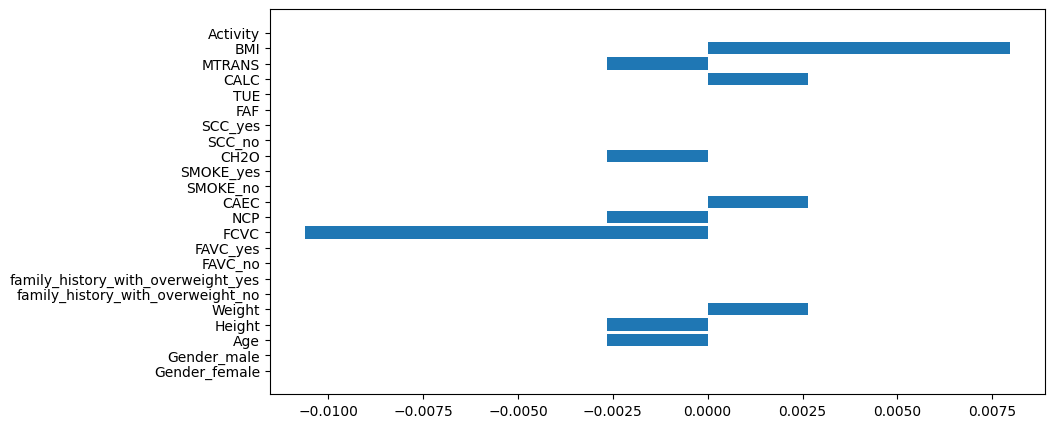

In [15]:
# Î∂ÑÎ¶¨ 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

# LR Î™®Îç∏ 
model = SVC()
model.fit(x_train, y_train)
pred = model.predict(x_test)
recall_baseline = recall_score(y_test, pred, average = 'weighted')

importances =[]

for col in X.columns : 
    x_drop = X.drop(columns = [col])
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size = 0.3, random_state = 1234)
    model = SVC()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    recall_drop = recall_score(y_test, pred, average = 'weighted')

    diff = recall_baseline - recall_drop 
    importances.append({
        'Features' : col, 
        'Drop Recall' : diff
    })

imp_df = pd.DataFrame(importances)
print(imp_df.sort_values(by = 'Drop Recall' , ascending = False))
print('''
1. Recall > 0 : Î≥ÄÏàòÎ•º Ï†úÍ±∞ÌñàÏùÑ ÎñÑ, RecallÏù¥ Í∞êÏÜå >> Ï¶â, Ìï¥Îãπ Î≥ÄÏàòÍ∞Ä ÏûàÏùÑÎïå Î™®Îç∏Ïùò ÏÑ±Îä•Ïù¥ Ï¢ãÎã§
2 .Recall < 0 : Î≥ÄÏàòÎ•º Ï†úÍ±∞ÌñàÏùÑ ÎñÑ, RecallÏù¥ Ï¶ùÍ∞Ä >> Î™®Îç∏Ïóê Î∞©Ìï¥ÏöîÏù∏Ïù¥ Îê† Ïàò ÏûàÎã§. 
''')

# ÏãúÍ∞ÅÌôî 
plt.figure(figsize = (10, 5))
plt.barh(imp_df['Features'], imp_df['Drop Recall'])
plt.show()

#### Maching Learning-2

In [16]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv')
df.head(3)

ID       ÌÇ§  weight      ÏÉùÎÖÑÏõîÏùº       Í±¥Í∞ïÍ≤ÄÏßÑÏùº  Í≥µÌïôÏó¨Î∂Ä  Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ  ÏïÑÏπ®ÏãùÏÇ¨Ïó¨Î∂Ä  \
0  ID_4135  169.01   65.47  20041003  2020_11_15     1       2       1   
1  ID_3289  181.62   69.36  19970725  2014_11_20     0       3       0   
2  ID_1847  160.89   65.12  20020921  2020_01_28     1       1       1   

   ÏùºÏ£ºÏùºÏö¥ÎèôÏãúÍ∞Ñ  ÏàòÎ©¥ÏãúÍ∞Ñ  ÏÑ±Î≥Ñ  
0      4.4   8.3  ÎÇ®ÏÑ±  
1      4.4   6.9  ÎÇ®ÏÑ±  
2      1.7   9.6  Ïó¨ÏÑ±

In [17]:
# bmi Í≥ÑÏÇ∞ 
df['bmi'] = df['weight'] / (df['ÌÇ§'] / 100 ) ** 2

In [18]:
df['ÏÉùÎÖÑÏõîÏùº'] = pd.to_datetime(df['ÏÉùÎÖÑÏõîÏùº'], format = '%Y%m%d')
df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'] = pd.to_datetime(df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'], format = '%Y_%m_%d')

df['sub_year'] = df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'].dt.year - df['ÏÉùÎÖÑÏõîÏùº'].dt.year
df['sub_days'] = (df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'] - df['ÏÉùÎÖÑÍ≤ÄÏßÑÏùº']).dt.days 

def age_split(x) : 
    year = x['sub_year']
    days = x['sub_days']

    if year >= 17 : 
        return 17 
    elif year == 16 and days > 364 :
        return 17 
    else : 
        return 16 

df['age'] = df[['sub_year','sub_days']].apply(age_split, axis = 1)
df['age'].value_counts()

In [19]:
# Í±¥Í∞ïÍ≤ÄÏßÑÏùº - ÏÉùÎÖÑÏõîÏùº = ÎÖÑÎèÑÎßå 
df['sub_year'] = df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'].dt.year - df['ÏÉùÎÖÑÏõîÏùº'].dt.year 

# ÎÇ†ÏßúÏóêÏÑú ÎÖÑÎèÑ * 365Ïùº Î∫¥Í∏∞ 
df['day_diff'] = (df['Í±¥Í∞ïÍ≤ÄÏßÑÏùº'] - df['ÏÉùÎÖÑÏõîÏùº']).dt.days - (df['sub_year'] * 365) 
df['age']= df.apply(lambda x : 17 if x['sub_year'] >= 17 or
                             x['sub_year'] == 16 and x['day_diff'] > 364 else 16,
                             axis = 1)
df['age'].value_counts()

age
17    5365
16    1436
Name: count, dtype: int64

In [20]:
# ÎßåÎÇòÏù¥ 
def bmi(x):
    BMI = x['bmi']
    age = x['age']
    gender = x['ÏÑ±Î≥Ñ']
    
## ÏÇ¨Ïù¥Í∞Ä ÏïÑÎãåÍ≤É ÌôïÏù∏ÌïòÍ∏∞ BMIÎ≤îÏúÑ Ï£ºÏùò
    if gender =='ÎÇ®ÏÑ±':
        if age ==17:
            if BMI >= 21.03 and BMI < 23.21:
                return 'Ï†ÅÏ†ï'
            else:
                return 'ÎπÑÏ†ÅÏ†ï'
    
        else:
            if BMI >= 21.18 and BMI < 23.45:
                return 'Ï†ÅÏ†ï'
            else:
                return 'ÎπÑÏ†ÅÏ†ï'            
    
    else:
        if age ==17:
            if BMI >= 20.03 and BMI < 22.39:
                return 'Ï†ÅÏ†ï'
            else:
                return 'ÎπÑÏ†ÅÏ†ï'
    
        else:
            if BMI >= 19.61 and BMI < 21.74:
                return 'Ï†ÅÏ†ï'
            else:
                return 'ÎπÑÏ†ÅÏ†ï'       
                
df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'] = df.apply(bmi, axis = 1)
df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'].value_counts()

Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä
Ï†ÅÏ†ï     3911
ÎπÑÏ†ÅÏ†ï    2890
Name: count, dtype: int64

 3-1ÏóêÏÑú Íµ¨Ìïú Ï†ÅÏ†ï Ï≤¥Ï§ë Ïó¨Î∂ÄÏôÄ ÎÇòÎ®∏ÏßÄ Ïª¨Îüº(Í≥µÌïôÏó¨Î∂Ä, ÏïÑÏπ®ÏãùÏÇ¨Ïó¨Î∂Ä, ÏùºÏ£ºÏùºÏö¥ÎèôÏãúÍ∞Ñ, Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ, ÏàòÎ©¥ÏãúÍ∞Ñ, ÏÑ±Î≥Ñ) Ïù¥ ÎèÖÎ¶ΩÏ†ÅÏù∏ÏßÄ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÌôïÏù∏

In [21]:
stat_df = df[['Í≥µÌïôÏó¨Î∂Ä','ÏïÑÏπ®ÏãùÏÇ¨Ïó¨Î∂Ä','ÏùºÏ£ºÏùºÏö¥ÎèôÏãúÍ∞Ñ','Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ','ÏàòÎ©¥ÏãúÍ∞Ñ','ÏÑ±Î≥Ñ','Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä']]

res = []
for col in stat_df.columns.difference(['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä']) : 
    if stat_df[col].nunique() <= 5 : 
        cross = pd.crosstab(stat_df[col], stat_df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä']) 
        stat, p_val, dof, _ = chi2_contingency(cross) 

        if p_val < 0.05 : 
            decision = 'Í∑ÄÎ¨¥Í∞ÄÏÑ§Í∏∞Í∞Å-ÎèÖÎ¶ΩÏù¥ÏïÑÎãàÎã§-Ïú†ÏùòÌïòÎã§'
        else : 
            decision = 'Í∑ÄÎ¨¥Í∞ÄÏÑ§Ï±ÑÌÉù-ÎèÖÎ¶ΩÏù¥Îã§'

    else : 
        g1 = stat_df[stat_df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'] == 'Ï†ÅÏ†ï'][col]
        g2 = stat_df[stat_df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'] == 'ÎπÑÏ†ÅÏ†ï'][col]

        stat, p_val = ttest_ind(g1, g2)

        if p_val < 0.05 : 
            decision = 'Í∑ÄÎ¨¥Í∞ÄÏÑ§Í∏∞Í∞Å-Ï∞®Ïù¥Í∞Ä ÏûàÎã§-Ïú†ÏùòÌïòÎã§'
        else : 
            decision = 'Í∑ÄÎ¨¥Í∞ÄÏÑ§Ï±ÑÌÉù-Ï∞®Ïù¥Í∞Ä ÏóÜÎã§'

    res.append([col, p_val , decision])

pd.DataFrame(res, columns = ['Columns','P_value', 'Decision'])

Columns   P_value            Decision
0     Í≥µÌïôÏó¨Î∂Ä  0.028622  Í∑ÄÎ¨¥Í∞ÄÏÑ§Í∏∞Í∞Å-ÎèÖÎ¶ΩÏù¥ÏïÑÎãàÎã§-Ïú†ÏùòÌïòÎã§
1       ÏÑ±Î≥Ñ  0.356966         Í∑ÄÎ¨¥Í∞ÄÏÑ§Ï±ÑÌÉù-ÎèÖÎ¶ΩÏù¥Îã§
2     ÏàòÎ©¥ÏãúÍ∞Ñ  0.008380  Í∑ÄÎ¨¥Í∞ÄÏÑ§Í∏∞Í∞Å-Ï∞®Ïù¥Í∞Ä ÏûàÎã§-Ïú†ÏùòÌïòÎã§
3   ÏïÑÏπ®ÏãùÏÇ¨Ïó¨Î∂Ä  0.545861         Í∑ÄÎ¨¥Í∞ÄÏÑ§Ï±ÑÌÉù-ÎèÖÎ¶ΩÏù¥Îã§
4  ÏùºÏ£ºÏùºÏö¥ÎèôÏãúÍ∞Ñ  0.526151       Í∑ÄÎ¨¥Í∞ÄÏÑ§Ï±ÑÌÉù-Ï∞®Ïù¥Í∞Ä ÏóÜÎã§
5   Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ  0.024652  Í∑ÄÎ¨¥Í∞ÄÏÑ§Í∏∞Í∞Å-ÎèÖÎ¶ΩÏù¥ÏïÑÎãàÎã§-Ïú†ÏùòÌïòÎã§

* 3.3 ÏúÑÏóêÏÑú Ïú†ÏùòÌïú Î≥ÄÏàòÎì§Îßå Í∞ÄÏßÄÍ≥† Ï†ÅÏ†ï Ï≤¥Ï§ë Ïó¨Î∂ÄÎ•º ÏòàÏ∏°ÌïòÎäî Î™®Îç∏ÏùÑ Íµ¨ÌòÑÌïòÍ≥† ÏÑ±Îä• ÌèâÍ∞Ä Î∞è Ìï¥ÏÑùÏùÑ ÌïòÎùº (Î°úÏßÄÏä§Ìã±ÌöåÍ∑Ä ,xgb)
- Î°úÏßÄÏä§Ìã±ÌöåÍ∑Ä Î™®Îç∏ÏùÄ Ïò§Ï¶àÎπÑÎ•º Íµ¨ÌïòÎùº xgbÏùò Í≤ΩÏö∞ Í∞Å ÌîºÏ≥êÏ§ëÏöîÎèÑÎ•º ÌôïÏù∏ÌïòÍ≥† ÏòàÏ∏°Ïóê ÏòÅÌñ•ÏùÑ Í∞ÄÏû• ÎØ∏ÏπòÎäî Î≥ÄÏàòÎ•º ÌôïÏù∏

  Model  Accuracy  F1_score
0    LG  0.570799  0.726762
1   xgb  0.532092  0.629988
LG Í≥µÌïôÏó¨Î∂Ä      1.119872
ÏàòÎ©¥ÏãúÍ∞Ñ      1.050529
Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ    0.978370
dtype: float64
xgb Í≥µÌïôÏó¨Î∂Ä      0.272632
ÏàòÎ©¥ÏãúÍ∞Ñ      0.331757
Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ    0.395612
dtype: float32


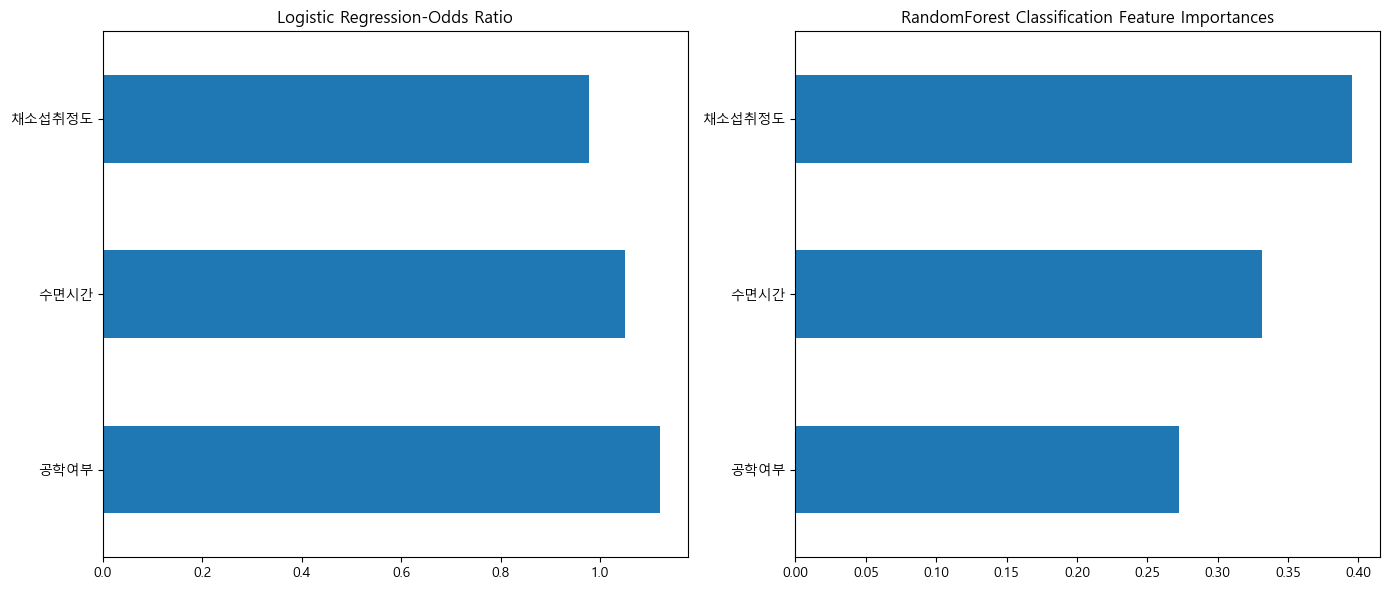

In [43]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

y = df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'].map({'Ï†ÅÏ†ï':1 , 'ÎπÑÏ†ÅÏ†ï' : 0})
X = df[['Í≥µÌïôÏó¨Î∂Ä','ÏàòÎ©¥ÏãúÍ∞Ñ','Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ']]

def classifying_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    return name, acc, f1 
res = []
model_lst = []
for name, model in [['LG', LogisticRegression()] , ['xgb' , XGBClassifier()]] : 
    name, acc, f1 = classifying_model(name, model) 
    model_lst.append([name, model])
    res.append({
        'Model' : name, 
        'Accuracy' : acc, 
        'F1_score' : f1
    })
print(pd.DataFrame(res)) 

fig, axes = plt.subplots(1,2, figsize = (14, 6))
for idx, (name, model) in enumerate(model_lst) : 
    if name == 'LG' : 
        odds = np.exp(model.coef_[0]) 
        features = model.feature_names_in_
        imp = pd.Series(odds, index = features)
        title = "Logistic Regression-Odds Ratio"
        
        
    elif name == 'xgb' : 
        importances = model.feature_importances_
        features = model.feature_names_in_
        imp = pd.Series(importances, index = features) 
        title = "RandomForest Classification Feature Importances"

    imp.plot(kind = 'barh', ax = axes[idx])
    axes[idx].set_title(title)
    plt.tight_layout()
    print(name,imp)

 3.4 Îëê Î™®Îç∏Ïùò roc-auc Í∑∏ÎûòÌîÑÎ•º ÌïòÎÇòÏùò Í∑∏ÎûòÌîÑÏóê Í≤πÏ≥ê Í∑∏Î†§Îùº

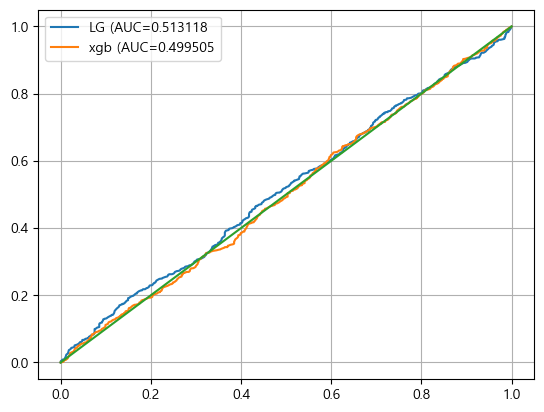

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score 

y = df['Ï†ÅÏ†ïÏ≤¥Ï§ëÏó¨Î∂Ä'].map({'Ï†ÅÏ†ï':1 , 'ÎπÑÏ†ÅÏ†ï' : 0})
X = df[['Í≥µÌïôÏó¨Î∂Ä','ÏàòÎ©¥ÏãúÍ∞Ñ','Ï±ÑÏÜåÏÑ≠Ï∑®Ï†ïÎèÑ']]

def classifying_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # predict_proba 
    pred_prob = model.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    auc = roc_auc_score(y_test, pred_prob)
    plt.plot(fpr, tpr, label = f'{name} (AUC={auc:2f}')
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred) 

    
    return name, acc, f1 

res = []
for name, model in [['LG', LogisticRegression()] , ['xgb' , XGBClassifier()]] : 
    name, acc, f1 = classifying_model(name, model) 
    model_lst.append([name, model])

plt.plot([0,1], [0,1])
plt.grid(True)
plt.legend()
plt.show()

Ïñ¥Îäê ÌöåÏÇ¨Ïùò Ï†úÌíà Î¨¥Í≤åÎäî N(?, 100) Ïùò Ï†ïÍ∑úÎ∂ÑÌè¨Î•º Îî∞Î•∏Îã§Í≥† ÏïåÎ†§Ï†∏ ÏûàÎã§. 
Ïù¥Îïå, ÏÇ¨Ï†ÑÏ†ÅÏúºÎ°ú Ïö∞Î¶¨Îäî Ï†úÌíàÏùò ÌèâÍ∑† Î¨¥Í≤å Í∞Ä Ï†ïÍ∑úÎ∂ÑÌè¨ N(100, 256) ÏóêÏÑú Ïò®Îã§Í≥† Í∞ÄÏ†ïÌïúÎã§. 
Ï†úÌíà Ï§ë ÌïòÎÇòÏùò Ïã§Ï†ú Ï∏°Ï†ïÎêú Î¨¥Í≤åÍ∞Ä 120kgÏùº Îïå, Ïù¥ Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÏÇ¨ÌõÑÎ∂ÑÌè¨Ïùò ÌèâÍ∑† 

$$
\mu_{\text{posterior}} = \left( \frac{\mu_0}{\tau_0^2} + \frac{x}{\sigma^2} \right) \Bigg/ \left( \frac{1}{\tau_0^2} + \frac{1}{\sigma^2} \right)
$$
$$
= \left( \frac{100}{256} + \frac{120}{100} \right) \Bigg/ \left( \frac{1}{256} + \frac{1}{100} \right)
= \frac{1.590625}{0.01390625} \approx 114.38
$$
---


In [49]:
x = 100 
var = 256 

x_obs = 120
var_obs = 100 

# Î≤†Ïù¥ÏßÄÏïà Ï†ïÍ∑úÎ∂ÑÌè¨ Ï∂îÎ°†
# ÏÇ¨ÌõÑ ÌèâÍ∑† 
(x / var + x_obs / var_obs) / (1/var + 1/var_obs)

114.3820224719101

Ïñ¥Îñ§ Ïã§Ìóò Ïû•ÎπÑÏùò Ï∏°Ï†ï Ïò§Ï∞®Îäî Ï†ïÍ∑úÎ∂ÑÌè¨ ùëÅ(ùúá,25)Î•º Îî∞Î•∏Îã§Í≥† ÏïåÎ†§Ï†∏ ÏûàÎã§.ÏÇ¨Ï†ÑÏ†ÅÏúºÎ°ú Ïö∞Î¶¨Îäî Ïù¥ Ïû•ÎπÑÏùò ÌèâÍ∑† Ïò§Ï∞® 
ŒºÍ∞Ä Ï†ïÍ∑úÎ∂ÑÌè¨ N(0,100)ÏóêÏÑú ÏôîÎã§Í≥† ÎØøÍ≥† ÏûàÎã§.
Ïã§Ï†úÎ°ú Ï∏°Ï†ïÎêú Ïò§Ï∞®Í∞íÏù¥ 8.0Ïù¥ÏóàÎã§Î©¥, Ïù¥ Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÏÇ¨ÌõÑÎ∂ÑÌè¨Ïùò ÌèâÍ∑†Í≥º Î∂ÑÏÇ∞ÏùÑ Í≥ÑÏÇ∞

In [51]:
x = 0 
var = 100 

obs_x = 8.0
obs_var = 25 

mean = (x/var + obs_x / obs_var) / (1/var + 1/obs_var)
print(mean)

var =  1 / (1/var + 1/obs_var)
print(var)

6.3999999999999995
20.0


In [52]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv',index_col = 0)
df.head(3)

A  B  C  D  E
contract_1  1  0  1  1  1
contract_2  0  1  0  1  0
contract_3  1  0  0  0  0

In [53]:
from statsmodels.stats.contingency_tables import cochrans_q

coc = cochrans_q(df)
print(coc.pvalue)

0.3406392758219471
